In [1]:
from imutils import paths
import numpy as np
import imutils
import pickle
import cv2
import os

detector = cv2.dnn.readNetFromCaffe(r'C:/Users/Pbl4/pbl4/davomat/xml_files/service/deploy.prototxt.txt',
                                    r'C:/Users/Pbl4/pbl4/davomat/xml_files/service/res10_300x300_ssd_iter_140000.caffemodel')
# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch(r'C:/Users/Pbl4/pbl4/davomat/dataset/openface_nn4.small2.v1.t7')

# grab the paths to the input images in our dataset
print("[INFO] quantifying faces...")
imagePaths = list(paths.list_images('origin_images'))
# initialize our lists of extracted facial embeddings and
# corresponding people names
knownEmbeddings = []
knownNames = []

# initialize the total number of faces processed
total = 0

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the person name from the image path
    print("[INFO] processing image {}/{}".format(i + 1, len(imagePaths)))
    name = imagePath.split(os.path.sep)[-2]
    # load the image, resize it to have a width of 600 pixels (while
    # maintaining the aspect ratio), and then grab the image
    # dimensions
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=160)
    (h, w) = image.shape[:2]
    # construct a blob from the image
    imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (160, 160)),
                                      1.0, (160, 160), (104.0, 177.0, 123.0),
                                      swapRB=False, crop=False)
    # apply OpenCV's deep learning-based face detector to localize
    # faces in the input image
    detector.setInput(imageBlob)
    detections = detector.forward()

    # ensure at least one face was found
    if len(detections) > 0:
        # we're making the assumption that each image has only ONE
        # face, so find the bounding box with the largest probability
        i = np.argmax(detections[0, 0, :, 2])
        confidence = detections[0, 0, i, 2]
        # ensure that the detection with the largest probability also
        # means our minimum probability test (thus helping filter out
        # weak detections)
        if confidence > 0.4:
            # compute the (x, y)-coordinates of the bounding box for
            # the face
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # extract the face ROI and grab the ROI dimensions
            face = image[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]
            # ensure the face width and height are sufficiently large
            if fW < 20 or fH < 20:
                continue

            # construct a blob for the face ROI, then pass the blob
            # through our face embedding model to obtain the 128-d
            # quantification of the face
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,
                                             (96, 96), (0, 0, 0),
                                             swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()
            # add the name of the person + corresponding face
            # embedding to their respective lists
            knownNames.append(name)
            knownEmbeddings.append(vec.flatten())
            total += 1

# dump the facial embeddings + names to disk
print("[INFO] serializing {} encodings...".format(total))
data = {"embeddings": knownEmbeddings, "names": knownNames}
f = open(r'C:/Users/Pbl4/pbl4/davomat/dataset/output/embeddings.pickle', "wb")
f.write(pickle.dumps(data))
f.close()


[INFO] loading face recognizer...
[INFO] quantifying faces...
[INFO] processing image 1/567
[INFO] processing image 2/567
[INFO] processing image 3/567
[INFO] processing image 4/567
[INFO] processing image 5/567
[INFO] processing image 6/567
[INFO] processing image 7/567
[INFO] processing image 8/567
[INFO] processing image 9/567
[INFO] processing image 10/567
[INFO] processing image 11/567
[INFO] processing image 12/567
[INFO] processing image 13/567
[INFO] processing image 14/567
[INFO] processing image 15/567
[INFO] processing image 16/567
[INFO] processing image 17/567
[INFO] processing image 18/567
[INFO] processing image 19/567
[INFO] processing image 20/567
[INFO] processing image 21/567
[INFO] processing image 22/567
[INFO] processing image 23/567
[INFO] processing image 24/567
[INFO] processing image 25/567
[INFO] processing image 26/567
[INFO] processing image 27/567
[INFO] processing image 28/567
[INFO] processing image 29/567
[INFO] processing image 30/567
[INFO] processing

c:\Users\Pbl4\pbl4\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Pbl4\pbl4\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Pbl4\pbl4\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Pbl4\pbl4\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Pbl4\pbl4\.venv\lib\site-packages\sklearn\neural_network\_multilayer_pe

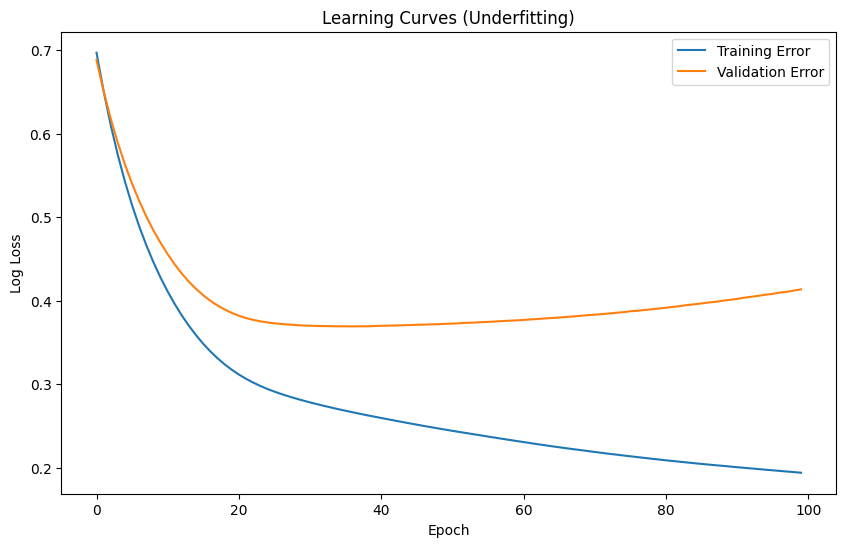

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import os

filename = r'C:/Users/Pbl4/pbl4/davomat/static/eda_img/Underfitting_or_Overfitting.png'

# Check if the file exists and delete it if it does
if os.path.exists(filename):
    os.remove(filename)

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True, random_state=42)

train_errors = []
val_errors = []

# Train the model for 100 epochs
for i in range(100):
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)
    val_pred = model.predict_proba(X_val)
    
    train_errors.append(log_loss(y_train, train_pred))
    val_errors.append(log_loss(y_val, val_pred))

# Determine if the model is underfitting or overfitting
final_train_error = train_errors[-1]
final_val_error = val_errors[-1]
label = ""

if final_train_error > 0.1 and final_val_error > 0.1:
    label = "Underfitting"
elif final_train_error < 0.1 and final_val_error > 0.2:
    label = "Overfitting"
else:
    label = "Just Right"

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Training Error')
plt.plot(val_errors, label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title(f'Learning Curves ({label})')
plt.legend()

plt.savefig(filename,dpi=300, bbox_inches='tight')
# plt.show()


In [91]:
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Load the face embeddings
print("[INFO] loading face embeddings...")
with open(r'C:/Users/Pbl4/pbl4/davomat/dataset/output/embeddings.pickle', "rb") as f:
    data = pickle.load(f)

# Convert embeddings to a NumPy array
embeddings = np.array(data["embeddings"])

# Encode the labels
print("[INFO] encoding labels...")
le = LabelEncoder()
labels = le.fit_transform(data["names"])

# Define the CNN model
print("[INFO] building and training model...")
model = Sequential([
    Dense(512, input_dim=embeddings.shape[1], activation='relu'),
    Dropout(0.25),    
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(len(np.unique(labels)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train the model
history= model.fit(embeddings, labels, epochs=100, batch_size=30, steps_per_epoch = 15000//32,validation_steps = 3000//32,validation_split=0.1, callbacks=[early_stopping])

# Save the model to disk
print("[INFO] saving model...")
model.save(r'C:/Users/Pbl4/pbl4/davomat/dataset/output/recognizer.h5')

# Save the label encoder to disk
print("[INFO] saving label encoder...")
with open(r'C:/Users/Pbl4/pbl4/davomat/dataset/output/le.pickle', "wb") as f:
    f.write(pickle.dumps(le))

print("[INFO] done")


[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] building and training model...
Epoch 1/100


c:\Users\Pbl4\pbl4\.venv\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - accuracy: 0.2215 - loss: 2.2648 - val_accuracy: 0.0000e+00 - val_loss: 3.6741
Epoch 2/100
  1/468 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.4000 - loss: 1.8326

C:\Users\asus\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step - accuracy: 0.5519 - loss: 1.4369 - val_accuracy: 0.2745 - val_loss: 5.3970
Epoch 3/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 161us/step - accuracy: 0.6898 - loss: 0.9335 - val_accuracy: 0.2549 - val_loss: 7.1699
Epoch 4/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 153us/step - accuracy: 0.6912 - loss: 0.8319 - val_accuracy: 0.2941 - val_loss: 6.6639
Epoch 5/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 124us/step - accuracy: 0.7547 - loss: 0.6730 - val_accuracy: 0.2941 - val_loss: 6.5569
Epoch 6/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - accuracy: 0.7994 - loss: 0.5418 - val_accuracy: 0.2941 - val_loss: 7.2067
Epoch 7/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 163us/step - accuracy: 0.8464 - loss: 0.4384 - val_accuracy: 0.2941 - val_loss: 8.4788
Epoch 8/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 156us/step - accuracy: 0.8220 - loss: 0.4455 - val_accuracy: 0.3137 - val_loss: 8.6993
Epoch 9/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 152us/step - accuracy: 0.8773 - loss: 0.3831 - val_

[INFO] saving model...
[INFO] saving label encoder...
[INFO] done


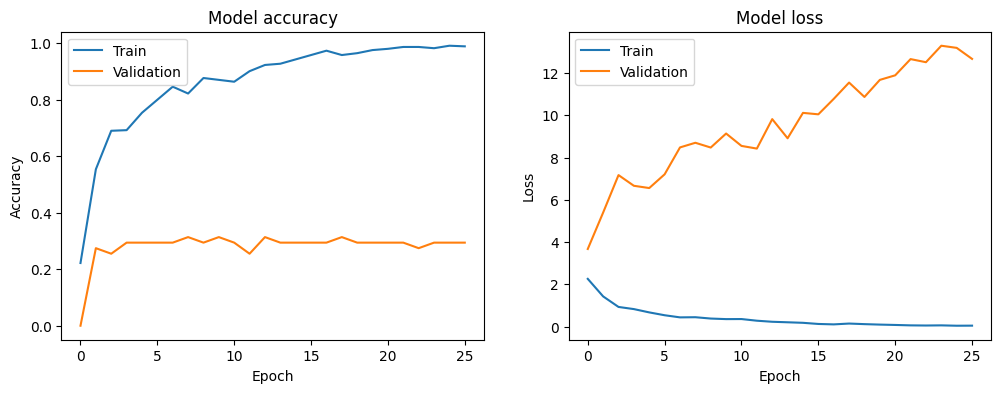

In [92]:
import os

filename = r'C:/Users/Pbl4/pbl4/davomat/static/eda_img/accuracy_and_loss.png'

# Check if the file exists and delete it if it does
if os.path.exists(filename):
    os.remove(filename)

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig(filename,dpi=300, bbox_inches='tight')


# plt.show()